# Insect Recognizer

## Introduction

This notebook is the starting point for insect recognizer.

## Data Importing

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "dataset/train"
val_dir = "dataset/valid"

train_datagen = ImageDataGenerator(
    rescale=1./255,       # normalize pixel values
    rotation_range=20,    # small random rotation
    zoom_range=0.2,       # small random zoom
    horizontal_flip=True  # flip image horizontally
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),   # resize all images
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 19149 images belonging to 32 classes.
Found 8649 images belonging to 32 classes.


## Data Understanding

### Classes

In [31]:
# Check the class labels detected by the generator
print("Class indices:", train_generator.class_indices)

# Reverse dictionary (to map index -> class name)
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

Class indices: {'Butterfly': 0, 'Dragonfly': 1, 'Grasshopper': 2, 'Ladybird': 3, 'Mosquito': 4, 'ant': 5, 'bee': 6, 'bee_apis': 7, 'bee_bombus': 8, 'beetle': 9, 'beetle_cocci': 10, 'beetle_oedem': 11, 'bug': 12, 'bug_grapho': 13, 'fly': 14, 'fly_empi': 15, 'fly_sarco': 16, 'fly_small': 17, 'hfly_episyr': 18, 'hfly_eristal': 19, 'hfly_eupeo': 20, 'hfly_myathr': 21, 'hfly_sphaero': 22, 'hfly_syrphus': 23, 'lepi': 24, 'none_bg': 25, 'none_bird': 26, 'none_dirt': 27, 'none_shadow': 28, 'other': 29, 'scorpionfly': 30, 'wasp': 31}
Class labels: ['Butterfly', 'Dragonfly', 'Grasshopper', 'Ladybird', 'Mosquito', 'ant', 'bee', 'bee_apis', 'bee_bombus', 'beetle', 'beetle_cocci', 'beetle_oedem', 'bug', 'bug_grapho', 'fly', 'fly_empi', 'fly_sarco', 'fly_small', 'hfly_episyr', 'hfly_eristal', 'hfly_eupeo', 'hfly_myathr', 'hfly_sphaero', 'hfly_syrphus', 'lepi', 'none_bg', 'none_bird', 'none_dirt', 'none_shadow', 'other', 'scorpionfly', 'wasp']


### Number of Images

In [32]:
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)

Number of training samples: 19149
Number of validation samples: 8649


### Some Images

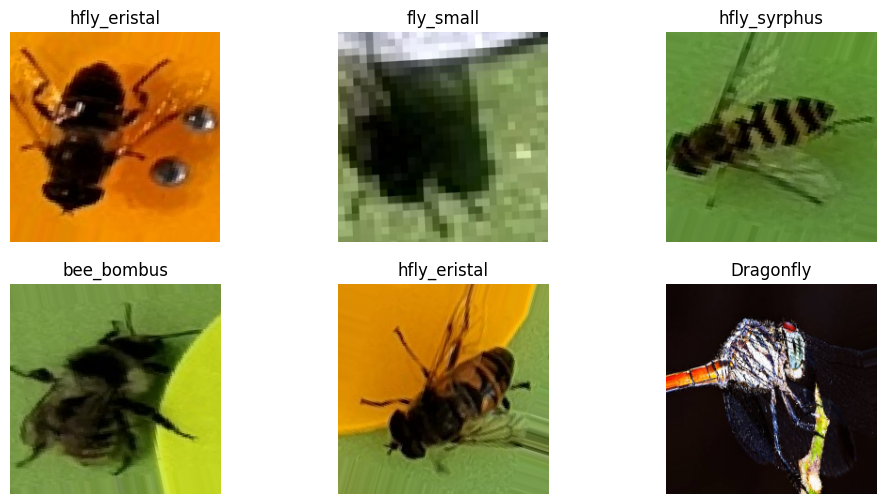

In [33]:
import matplotlib.pyplot as plt

# Get one batch of images and labels
images, labels = next(train_generator)

# Show first 6 images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].argmax()])  # get class name
    plt.axis("off")
plt.show()


### Class Distribution

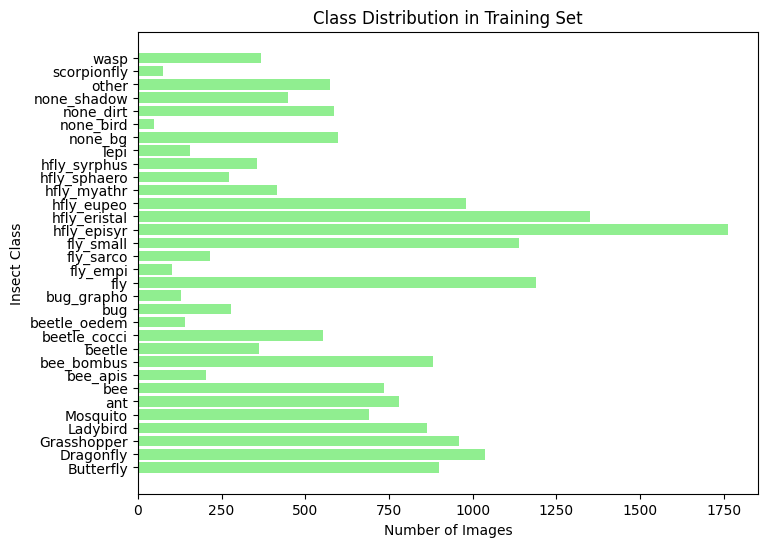

In [34]:
import numpy as np

# Count number of samples for each class in training set
train_counts = np.bincount(train_generator.classes)

# Plot horizontal bar chart
plt.figure(figsize=(8,6))   # bigger figure
plt.barh(class_labels, train_counts, color="lightgreen")
plt.xlabel("Number of Images")
plt.ylabel("Insect Class")
plt.title("Class Distribution in Training Set")
plt.show()
